# Data Augmentation Using Numpy

In [83]:
from features.samplers import PairSampler, TripletSampler
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
import numpy as np
import scipy
from matplotlib import pyplot as plt

In [94]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

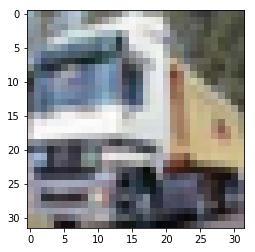

In [107]:
plt.imshow(x_train[1])
plt.show()

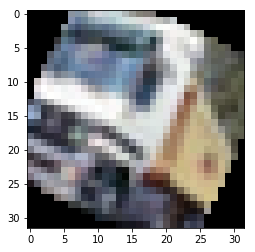

In [113]:
new_img = scipy.ndimage.rotate(x_train[1], -25, reshape=False)
plt.imshow(new_img)
plt.show()

In [112]:
new_img.shape

(32, 32, 3)

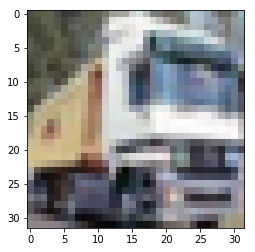

In [102]:
plt.imshow(np.flip(x_train[1], axis=1))
plt.show()

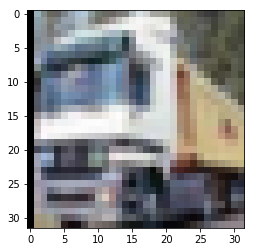

(32, 32, 3)

In [115]:
shift1, shift2 = np.random.randint(low=-4, high=4), np.random.randint(low=-4, high=4)
new_img = scipy.ndimage.shift(x_train[1], (shift1,shift2,0))
plt.imshow(new_img)
plt.show()
new_img.shape

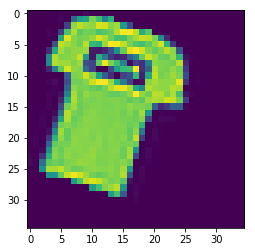

In [92]:
# rotate image
angle = np.random.uniform(low=-45, high=45)
new_img = scipy.ndimage.rotate(x_train[1], angle)
# flip image
if np.random.uniform(low=0, high=1) > 0.5:
    new_img = np.flip(new_img, axis=1)
# shift image
shift1, shift2 = np.random.randint(low=-4, high=4), np.random.randint(low=-4, high=4)
new_img = scipy.ndimage.shift(new_img, (shift1,shift2))
plt.imshow(new_img)
plt.show()

In [69]:
y_train.shape[0]

60000

# Data Augmentation Using Keras

In [3]:
from keras.datasets import cifar10, mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))

In [5]:
datagen = ImageDataGenerator(        
            featurewise_center=True,
            featurewise_std_normalization=True,
            zca_whitening=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.05,
            zoom_range=0.1,
            horizontal_flip=False,
            vertical_flip=False,
            channel_shift_range=0.1)

In [6]:
datagen.fit(x_train)

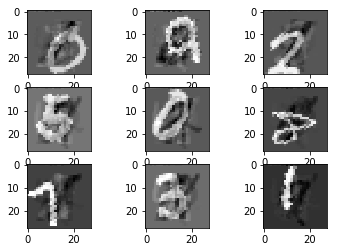

[0 9 2 5 0 8 7 3 1]


In [107]:
# configure batch size and retrieve one batch of images
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape((28, 28)), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    print(y_batch)
    break

In [ ]:
class PairSampler:
    
    def __init__(self, data, sample_size, flip=True):
        x, y = data
        datagen = ImageDataGenerator(        
            featurewise_center=True,
            featurewise_std_normalization=True,
            zca_whitening=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.05,
            zoom_range=0.1,
            horizontal_flip=flip,
            vertical_flip=flip,
            channel_shift_range=0.1)
        datagen.fit(x)
        self.sampler = datagen.flow(x, y, batch_size=2*sample_size)
        
    def sample(self):
        return self.sampler.next()

In [ ]:
class TripletSampler:
    
    def __init__(self, data, sample_size, flip=True):
        x, y = data
        self.num_classes = len(np.unique(y))
        datagen = ImageDataGenerator(        
            featurewise_center=True,
            featurewise_std_normalization=True,
            zca_whitening=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.05,
            zoom_range=0.1,
            horizontal_flip=flip,
            vertical_flip=flip,
            channel_shift_range=0.1)
        datagen.fit(x)        
        self.sampler = datagen.flow(x, y, batch_size=4*sample_size)
        self.sample_size = sample_size
        
    def sample(self):
        x, y = self.sampler.next()       
        x1, y1 = self.x[:self.sample_size], self.y[:self.sample_size]
        x_other, y_other = self.x[self.sample_size:], self.y[self.sample_size:]
        for c in range(self.num_classes):
            n = np.sum(y1 == c)
            idx_same = (x_other == c)
            idx_diff = (x_other != c)
            sample_same = np.random.random_integers(0,len(idx_same)-1,n)
            sample_diff = np.random.random_integers(0,len(idx_other)-1,n)
            x2 = idx_same[idx_same][sample_same]
            y2 = idx_same[idx_same][sample_same]
            x3 = x_other[idx_diff][sample_diff]
            y3 = y_other[idx_diff][sample_diff]
        sample_x = np.concatenate((x1, x2, x3))
        sample_y = np.concatenate((y1, y2, y3))
        return sample_x, sample_y

# Compare classification results

In [8]:
import numpy as np
import keras as keras
import scipy
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras import regularizers
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.preprocessing.image import ImageDataGenerator

In [17]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=1, activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Baseline

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))

# del model
model = get_model()
model.fit(x_train, y_train, batch_size=128, epochs=10)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/10
60000/60000 [==============================] - 5s 83us/step - loss: 15.6283 - acc: 0.1041
Epoch 2/10
60000/60000 [==============================] - 3s 57us/step - loss: 1.6557 - acc: 0.8628
Epoch 3/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1513 - acc: 0.9815
Epoch 4/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.1118 - acc: 0.9828
Epoch 5/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.0905 - acc: 0.9857
Epoch 6/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.0847 - acc: 0.9864
Epoch 7/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.0780 - acc: 0.9875
Epoch 8/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.0748 - acc: 0.9876
Epoch 9/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.0714 - acc: 0.9886
Epoch 10/10
10000/10000 [==============================] - 0s 23us/step


[0.07305961967110634, 0.987]

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))

del model
model = get_model()
model.fit(x_train, y_train, batch_size=128, epochs=10)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/10
60000/60000 [==============================] - 4s 62us/step - loss: 15.2476 - acc: 0.1986
Epoch 2/10
60000/60000 [==============================] - 3s 57us/step - loss: 5.0008 - acc: 0.6126
Epoch 3/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.5144 - acc: 0.8814
Epoch 4/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.4016 - acc: 0.8947
Epoch 5/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.3588 - acc: 0.9016
Epoch 6/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.3318 - acc: 0.9086
Epoch 7/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.3162 - acc: 0.9115
Epoch 8/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.2991 - acc: 0.9161
Epoch 9/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.2905 - acc: 0.9180
Epoch 10/10
10000/10000 [==============================] - 0s 25us/step


[0.32331138973236084, 0.9106]

In [19]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

del model
model = get_model()
model.fit(x_train, y_train, batch_size=128, epochs=20)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/20
50000/50000 [==============================] - 4s 90us/step - loss: 5.9952 - acc: 0.4206
Epoch 2/20
50000/50000 [==============================] - 4s 83us/step - loss: 2.4546 - acc: 0.5851
Epoch 3/20
50000/50000 [==============================] - 4s 82us/step - loss: 1.5656 - acc: 0.6431
Epoch 4/20
50000/50000 [==============================] - 4s 83us/step - loss: 1.2044 - acc: 0.6792
Epoch 5/20
50000/50000 [==============================] - 4s 83us/step - loss: 1.0256 - acc: 0.7076
Epoch 6/20
50000/50000 [==============================] - 4s 83us/step - loss: 0.9329 - acc: 0.7248
Epoch 7/20
50000/50000 [==============================] - 4s 83us/step - loss: 0.8691 - acc: 0.7427
Epoch 8/20
50000/50000 [==============================] - 4s 82us/step - loss: 0.8148 - acc: 0.7594
Epoch 9/20
50000/50000 [==============================] - 4s 83us/step - loss: 0.7704 - acc: 0.7748
Epoch 10/20
50000/50000 [==============================] - 4s 82us/step - loss: 0.7383 - acc: 0.7813

[0.9566268188476562, 0.737]

## Keras

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))

del model
model = get_model()

datagen = ImageDataGenerator(        
            featurewise_center=True,
            featurewise_std_normalization=True,
            zca_whitening=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.05,
            zoom_range=0.1,
            horizontal_flip=False,
            vertical_flip=False,
            channel_shift_range=0.1)
datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch=len(x_train) / 128, epochs=10)

Epoch 1/10
469/468 [==============================] - 42s 90ms/step - loss: 2.1269 - acc: 0.6113
Epoch 2/10
469/468 [==============================] - 35s 75ms/step - loss: 0.7871 - acc: 0.8500
Epoch 3/10
469/468 [==============================] - 34s 72ms/step - loss: 0.6151 - acc: 0.8868
Epoch 4/10
469/468 [==============================] - 34s 73ms/step - loss: 0.5343 - acc: 0.9050
Epoch 5/10
469/468 [==============================] - 37s 79ms/step - loss: 0.4779 - acc: 0.9144
Epoch 6/10
469/468 [==============================] - 50s 107ms/step - loss: 0.4448 - acc: 0.9210
Epoch 7/10
469/468 [==============================] - 50s 106ms/step - loss: 0.4197 - acc: 0.9238
Epoch 8/10
469/468 [==============================] - 37s 78ms/step - loss: 0.3894 - acc: 0.9298
Epoch 9/10
469/468 [==============================] - 36s 76ms/step - loss: 0.3713 - acc: 0.9334
Epoch 10/10
469/468 [==============================] - 36s 76ms/step - loss: 0.3632 - acc: 0.9340


In [6]:
model.evaluate(x_test, y_test, batch_size=128)

10000/10000 [==============================] - 0s 23us/step


[2.9910585758209227, 0.8208]

In [7]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))

del model
model = get_model()

datagen = ImageDataGenerator(        
            featurewise_center=True,
            featurewise_std_normalization=True,
            zca_whitening=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.05,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            channel_shift_range=0.1)
datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch=len(x_train) / 128, epochs=10)

Epoch 1/10
469/468 [==============================] - 37s 79ms/step - loss: 1.9160 - acc: 0.5724
Epoch 2/10
469/468 [==============================] - 52s 111ms/step - loss: 1.0841 - acc: 0.6757
Epoch 3/10
469/468 [==============================] - 38s 80ms/step - loss: 1.0059 - acc: 0.6943
Epoch 4/10
469/468 [==============================] - 38s 80ms/step - loss: 0.9546 - acc: 0.7095
Epoch 5/10
469/468 [==============================] - 37s 79ms/step - loss: 0.9176 - acc: 0.7203
Epoch 6/10
469/468 [==============================] - 41s 88ms/step - loss: 0.8942 - acc: 0.7283
Epoch 7/10
469/468 [==============================] - 39s 82ms/step - loss: 0.8656 - acc: 0.7345
Epoch 8/10
469/468 [==============================] - 37s 79ms/step - loss: 0.8496 - acc: 0.7393
Epoch 9/10
469/468 [==============================] - 52s 112ms/step - loss: 0.8336 - acc: 0.7435
Epoch 10/10
469/468 [==============================] - 38s 82ms/step - loss: 0.8193 - acc: 0.7471


In [8]:
model.evaluate(x_test, y_test, batch_size=128)

10000/10000 [==============================] - 0s 25us/step


[11.6207580368042, 0.2787]

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))

del model
model = get_model()

datagen = ImageDataGenerator(        
            featurewise_center=True,
            featurewise_std_normalization=True,
            zca_whitening=True,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.05,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            channel_shift_range=0.1)
datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch=len(x_train) / 128, epochs=5)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/5
469/468 [==============================] - 54s 116ms/step - loss: 1.7933 - acc: 0.6561
Epoch 2/5
469/468 [==============================] - 38s 80ms/step - loss: 0.9336 - acc: 0.7299
Epoch 3/5
469/468 [==============================] - 58s 123ms/step - loss: 0.8673 - acc: 0.7459
Epoch 4/5
469/468 [==============================] - 39s 82ms/step - loss: 0.8275 - acc: 0.7553
Epoch 5/5
10000/10000 [==============================] - 0s 34us/step


[12.908195848083496, 0.2017]

## Numpy

In [14]:
def augment_img(img, flip=False):
    # rotate image
    angle = np.random.uniform(low=-25, high=25)
    new_img = scipy.ndimage.rotate(img, angle, reshape=False)
    # flip image
    if flip and np.random.uniform(low=0, high=1) > 0.5:
        new_img = np.flip(new_img, axis=1)
    # shift image
    shift1, shift2 = np.random.randint(low=-4, high=4), np.random.randint(low=-4, high=4)
    new_img = scipy.ndimage.shift(new_img, (shift1,shift2,0))
    return new_img

def augment_data(x_train, y_train, factor=1, flip=True):
    N = y_train.shape[0]
    x_augment, y_augment = np.zeros(x_train.shape), np.zeros(y_train.shape, dtype='int8')    
    for i in range(int(factor*N)):
        j = np.random.randint(low=0, high=N)
        x_augment[i], y_augment[i] = augment_img(x_train[j], flip), y_train[j]
    new_x = np.concatenate((x_train, x_augment))
    new_y = np.concatenate((y_train, y_augment))
    return new_x, new_y 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))

del model
model = get_model()
x_train, y_train = augment_data(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=10)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/10
120000/120000 [==============================] - 7s 62us/step - loss: 15.2217 - acc: 0.1003
Epoch 2/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.7281 - acc: 0.8791
Epoch 3/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.2449 - acc: 0.9549
Epoch 4/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.2129 - acc: 0.9600
Epoch 5/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.1942 - acc: 0.9635
Epoch 6/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.1871 - acc: 0.9654
Epoch 7/10
120000/120000 [==============================] - 7s 60us/step - loss: 0.1808 - acc: 0.9667
Epoch 8/10
 56576/120000 [=============>................] - ETA: 3s - loss: 0.1714 - acc: 0.9689

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32').reshape((-1,28,28,1))
x_test = x_test.astype('float32').reshape((-1,28,28,1))

del model
model = get_model()
x_train, y_train = augment_data(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=10)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/10
120000/120000 [==============================] - 7s 62us/step - loss: 2.6644 - acc: 0.7412
Epoch 2/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.6625 - acc: 0.8188
Epoch 3/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.5615 - acc: 0.8384
Epoch 4/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.5141 - acc: 0.8490
Epoch 5/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.4910 - acc: 0.8558
Epoch 6/10
120000/120000 [==============================] - 7s 61us/step - loss: 0.4705 - acc: 0.8616
Epoch 7/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.4549 - acc: 0.8655
Epoch 8/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.4387 - acc: 0.8711
Epoch 9/10
120000/120000 [==============================] - 7s 59us/step - loss: 0.4257 - acc: 0.8745
Epoch 10/10
10000/10000 [==============================] - 0s 31us/step


[0.362618873500824, 0.8982]

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, y_train = augment_data(x_train, y_train)

del model
model = get_model()
model.fit(x_train, y_train, batch_size=128, epochs=10)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/10
100000/100000 [==============================] - 8s 76us/step - loss: 15.0497 - acc: 0.0992
Epoch 2/10
100000/100000 [==============================] - 7s 74us/step - loss: 12.9878 - acc: 0.1001
Epoch 3/10
100000/100000 [==============================] - 7s 74us/step - loss: 2.3447 - acc: 0.1000
Epoch 4/10
100000/100000 [==============================] - 7s 73us/step - loss: 2.3177 - acc: 0.0997
Epoch 5/10
100000/100000 [==============================] - 7s 74us/step - loss: 2.3107 - acc: 0.1008
Epoch 6/10
100000/100000 [==============================] - 7s 74us/step - loss: 2.3063 - acc: 0.1007
Epoch 7/10
100000/100000 [==============================] - 7s 74us/step - loss: 2.3044 - acc: 0.0980
Epoch 8/10
100000/100000 [==============================] - 7s 74us/step - loss: 2.2746 - acc: 0.1350
Epoch 9/10
100000/100000 [==============================] - 7s 75us/step - loss: 1.6804 - acc: 0.4270
Epoch 10/10
10000/10000 [==============================] - 0s 40us/step


[1.3144206365585327, 0.5567]

In [18]:
del model
model = get_model()
model.fit(x_train, y_train, batch_size=128, epochs=20)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/20
100000/100000 [==============================] - 8s 84us/step - loss: 13.0502 - acc: 0.1160
Epoch 2/20
100000/100000 [==============================] - 8s 81us/step - loss: 1.6108 - acc: 0.4465
Epoch 3/20
100000/100000 [==============================] - 8s 81us/step - loss: 1.2342 - acc: 0.5923
Epoch 4/20
100000/100000 [==============================] - 8s 81us/step - loss: 1.0772 - acc: 0.6519
Epoch 5/20
100000/100000 [==============================] - 8s 81us/step - loss: 0.9774 - acc: 0.6859
Epoch 6/20
100000/100000 [==============================] - 8s 81us/step - loss: 0.9108 - acc: 0.7095
Epoch 7/20
100000/100000 [==============================] - 8s 81us/step - loss: 0.8582 - acc: 0.7281
Epoch 8/20
100000/100000 [==============================] - 8s 81us/step - loss: 0.8136 - acc: 0.7436
Epoch 9/20
100000/100000 [==============================] - 8s 81us/step - loss: 0.7778 - acc: 0.7541
Epoch 10/20
100000/100000 [==============================] - 8s 81us/step - loss:

[0.8095612321853638, 0.7634]